In [41]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from scipy import stats

In [42]:
base_path = Path.cwd().resolve()
print(base_path)

C:\Users\Matth\OneDrive\Desktop\Singlelayer_NN_Model


In [43]:
data_dir = "2020_LaserNetCSUCombinedData"
os.chdir(f'{base_path}\\{data_dir}\\SCRAM\\Code')
from import_scram import SCRAM
from simulate_scram import SCRAMTarget
os.chdir(base_path)

In [44]:
#Define energy axes, density layers, and temp layers


def plotter(dens, temp, flor, err,dx=0.5e-4, dens2=3, temp2=3, flor2=0.003, err2=0, dx2 = 0.5e-4, ploton=False, compare = False):
    en_VH = np.linspace(8,9.97,2995) #Spectral range of front side von Hamos spectrometer
    en_HR = np.linspace(8,8.45,2995) #Spectral range of rear side spherical crystal spectrometer
    dens = [dens] #Solid Density copper LOW BoUND: 2.23; HIGH BOUND 18.00
    temp = [temp] #Reasonable temperature of 3.5 keV #LOW BOUND 0.10; HIGH BOUND 6.40
    dens2 = [dens2]
    temp2 = [temp2]
     #Single layer of thickness 500 nm

    #get interpolators for j,k, and fluorescence
    scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
    j,k,j_f,k_f,fh,fj = scram.get_scram_intrp(dx) #Extracts j, k from SCRAM

    target1 = SCRAMTarget(dens,temp,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx) #Generates class object with the specified parameters
    target2 = SCRAMTarget(dens2,temp2,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx2)
    #generating test spectra with noise
    #target = SCRAMTarget(dens,temp,j,k,en_VH,en_HR,dx)
    test_VH, test_HR = target1.model(dens,temp,flor,100)
    test_VH2, test_HR2 = target2.model(dens2,temp2,flor2,100)
    baselineVH,baselineHR = np.zeros((0, 2995)),np.zeros((0, 2995))

   

    
    error = err #controls how noisy the spectra are
    error2 = err2
    noise_VH = np.random.normal(0,error*np.std(test_VH),en_VH.shape)
    noise_HR = np.random.normal(0,error*np.std(test_HR),en_HR.shape)
    
    noise_VH2 = np.random.normal(0,error2*np.std(test_VH2),en_VH.shape)
    noise_HR2 = np.random.normal(0,error2*np.std(test_HR2),en_HR.shape)
    
    if ploton == True:
        fig, axs = plt.subplots(nrows = 2, ncols = 1)
        fig.set_figwidth(10)
        fig.set_figheight(8)
        fig.tight_layout(pad = 4)
        fig.suptitle('Simulated Spectra with Gaussian Noise')

        axs[0].plot(en_VH,test_VH+noise_VH, label = 'Simulated')
        axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[0].set(xlabel = 'Photon Energy [keV]')
        
        axs[1].plot(en_HR,test_HR+noise_HR)
        axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[1].set(xlabel = 'Photon Energy [keV]');
        
        if compare == True:
            axs[0].plot(en_VH,test_VH2+noise_VH2, label = 'Predicted', linestyle = '--')
            axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[0].set(xlabel = 'Photon Energy [keV]')
            axs[0].legend()

            axs[1].plot(en_HR,test_HR2+noise_HR2, linestyle = '--')
            axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[1].set(xlabel = 'Photon Energy [keV]');
            axs[1].legend()
        colors = np.random.rand(3,3)
        axs[0].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[0].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[0].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[0].axvspan(8.62,8.72,alpha=0.3,color=(0.3,0.5,0.7),label =r'$Ly \alpha$')
        axs[0].axvspan(8.87,8.92,alpha=0.3,color=(0.4,0.4,0.8),label =r'$K \beta$')
        axs[0].axvspan(9.72,9.9,alpha=0.3,color=(0.7,0.7,0.9),label =r'$He \beta$')
        axs[0].legend()

        axs[1].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[1].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[1].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[1].legend()
    intensity = []
    intensity.append(test_VH+noise_VH)

    energy_intensity_df = pd.concat([pd.DataFrame(en_VH.reshape(1,-1)),pd.DataFrame(intensity)])
    return energy_intensity_df

In [45]:
#Define energy axes, density layers, and temp layers


def plotter2(dens, temp, flor, err,dx=0.5e-4, exp_specVH = [],exp_specHR=[],  err2=0, dx2 = 0.5e-4, ploton=False, compare = False,crop=False):
    en_VH = np.linspace(8,9.97,2995) #Spectral range of front side von Hamos spectrometer
    en_HR = np.linspace(8,8.45,2995) #Spectral range of rear side spherical crystal spectrometer
    dens = [dens] #Solid Density copper LOW BoUND: 2.23; HIGH BOUND 18.00
    temp = [temp] #Reasonable temperature of 3.5 keV #LOW BOUND 0.10; HIGH BOUND 6.40
     #Single layer of thickness 500 nm

    #get interpolators for j,k, and fluorescence
    scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
    j,k,j_f,k_f,fh,fj = scram.get_scram_intrp(dx) #Extracts j, k from SCRAM


    if ploton == True:
        fig, axs = plt.subplots(nrows = 2, ncols = 1)
        fig.set_figwidth(10)
        fig.set_figheight(8)
        fig.tight_layout(pad = 4)
        fig.suptitle('Simulated Spectra with Gaussian Noise')

        axs[0].plot(en_VH,exp_specVH, label = 'Experimental')
        axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[0].set(xlabel = 'Photon Energy [keV]')
        if crop == True:
            axs[0].set_xlim(8,8.45)

        axs[1].plot(en_HR,exp_specHR)
        axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[1].set(xlabel = 'Photon Energy [keV]');
        axs[1].legend()
        

        
        if compare == True:
            target1 = SCRAMTarget(dens,temp,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx) #Generates class object with the specified parameters
    
            #generating test spectra with noise
            #target = SCRAMTarget(dens,temp,j,k,en_VH,en_HR,dx)
            test_VH, test_HR = target1.model(dens,temp,flor,100)

            error = err #controls how noisy the spectra are
            error2 = err2
            noise_VH = np.random.normal(0,error*np.std(test_VH),en_VH.shape)
            noise_HR = np.random.normal(0,error*np.std(test_HR),en_HR.shape)
            
            
            axs[0].plot(en_VH,test_VH+noise_VH, linestyle = '--',label = 'Predicted')
            axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[0].set(xlabel = 'Photon Energy [keV]')
            axs[0].legend()
        
            axs[1].plot(en_HR,test_HR+noise_HR,  linestyle = '--')
            axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[1].set(xlabel = 'Photon Energy [keV]');
        colors = np.random.rand(3,3)
        axs[0].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[0].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[0].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[0].axvspan(8.62,8.72,alpha=0.3,color=(0.3,0.5,0.7),label =r'$Ly \alpha$')
        axs[0].axvspan(8.87,8.92,alpha=0.3,color=(0.4,0.4,0.8),label =r'$K \beta$')
        axs[0].axvspan(9.72,9.9,alpha=0.3,color=(0.7,0.7,0.9),label =r'$He \beta$')
        axs[0].legend()

        axs[1].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[1].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[1].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[1].legend()

    
    
    return test_VH+noise_VH

In [46]:
megadata = joblib.load(f'{base_path}\\processedhigh\\allpreprocEID.pkl')
DensityScaler = joblib.load(f'{base_path}\\processedhigh\\DensityScaler.pkl')
TempScaler = joblib.load(f'{base_path}\\processedhigh\\TempScaler.pkl')
# HEFScaler = joblib.load(f'{base_path}\\processedhigh\\HEFScaler.pkl')
DTF_df = joblib.load(f'{base_path}\\processedhigh\\DTDscaledlog10.pkl')
EIDPCA = joblib.load(f'{base_path}\\processedhigh\\EIDPCA.pkl')


In [47]:
DTF_df = DTF_df.iloc[:,:2]

In [48]:
megadata

,0,1,2,3,4,5,6,7
0,23.687584,-1.349316,-4.787875,0.017736,0.123569,8.357215,1.086440,1.716560
1,3.913816,-3.840642,-6.546901,-1.366161,1.231527,14.547206,6.312618,4.682158
2,-8.404073,4.774893,-9.696408,-2.056585,2.268113,27.275652,19.284980,11.452236
3,0.741070,-1.691017,-8.674565,-0.253808,0.606706,17.034304,8.887051,5.744522
4,-22.498126,7.794314,-1.290906,-3.438996,3.103925,30.104732,24.402572,9.028531
...,...,...,...,...,...,...,...,...
64995,-12.107470,-1.311560,-1.977219,-2.536193,2.362049,18.712338,12.146738,6.009566
64996,25.672888,-5.081343,2.273720,-0.081190,0.054265,1.032589,0.070263,0.139315
64997,13.626355,1.643124,-9.017724,-1.978354,2.429986,17.006985,6.756178,5.876695
64998,0.860944,-15.673269,6.591321,-0.233361,0.206888,4.067999,0.802809,0.900054


In [49]:
EID_train, EID_val = train_test_split(megadata, test_size=0.2, random_state=42)

In [50]:
DTD_train, DTD_val = train_test_split(DTF_df, test_size=0.2, random_state=42)

In [51]:
X_train = torch.tensor(EID_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(DTD_train.to_numpy(), dtype=torch.float32)

X_val = torch.tensor(EID_val.to_numpy(), dtype=torch.float32)
y_val = torch.tensor(DTD_val.to_numpy(), dtype=torch.float32)

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

valset = TensorDataset(X_val, y_val)
val_loader = DataLoader(valset, batch_size=32, shuffle=False)

In [52]:


# class FeedforwardNN(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
#         super(FeedforwardNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.dropout3 = nn.Dropout(p=0.1)
#         self.fc4 = nn.Linear(hidden_size3, output_size)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.leaky_relu(out)
#         out = self.fc3(out)
#         out = self.relu(out)
#         out = self.fc4(out)
#         out = self.sigmoid(out)  # Ensures output is between 0 and 1
        
#         return out

# # Example usage:
# # model = FeedforwardNN(input_size=..., hidden_size1=..., hidden_size2=..., hidden_size3=..., output_size=...)
# # output = model(torch.randn(1, input_size))


In [53]:

class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        #self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        #self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        #self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)

        #self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        out = self.fc1(x)
        #out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        #out = self.bn2(out)
        out = self.leaky_relu(out)
        #out = self.dropout2(out)
        out = self.fc3(out)
        #out = self.bn3(out)
        out = self.relu(out)
        out = self.fc4(out)
        
        return out
# Example usage:



In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 8  # Number of PCA components
hidden_size1 = 128
hidden_size2 = 256
hidden_size3 = 128



output_size = 2   # Number of coefficients
model = FeedforwardNN(input_size, hidden_size1,hidden_size2, hidden_size3, output_size).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [55]:

# Initialize weights
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(weights_init)


FeedforwardNN(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)

In [56]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    return val_loss / len(val_loader.dataset)

In [57]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [58]:

model = model.cpu()
model.train()

num_epochs = 500
val_loss_data = []
training_loss_data = []
batch_acc = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss/len(dataloader)
    val_loss = validate_model(model, val_loader, criterion, device)
    acc = 1
    print(f' {device} Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}; Val loss = {val_loss};')
    val_loss_data.append(val_loss)
    training_loss_data.append(avg_epoch_loss)
    scheduler.step(val_loss)


 cpu Epoch [1/500], Loss: 0.7164; Val loss = 0.04690793623374059;
 cpu Epoch [2/500], Loss: 0.0147; Val loss = 0.000520083223344185;
 cpu Epoch [3/500], Loss: 0.0005; Val loss = 0.00014838004522383787;
 cpu Epoch [4/500], Loss: 0.0005; Val loss = 0.00019759855463276975;
 cpu Epoch [5/500], Loss: 0.0002; Val loss = 9.386677980700579e-05;
 cpu Epoch [6/500], Loss: 0.0002; Val loss = 8.326256418009647e-05;
 cpu Epoch [7/500], Loss: 0.0002; Val loss = 0.00029153994959779086;
 cpu Epoch [8/500], Loss: 0.0002; Val loss = 0.0001003582185277572;
 cpu Epoch [9/500], Loss: 0.0001; Val loss = 6.386913386478018e-05;
 cpu Epoch [10/500], Loss: 0.0001; Val loss = 5.9493399675165374e-05;
 cpu Epoch [11/500], Loss: 0.0001; Val loss = 5.526882442287528e-05;
 cpu Epoch [12/500], Loss: 0.0001; Val loss = 6.700399924123374e-05;


KeyboardInterrupt: 

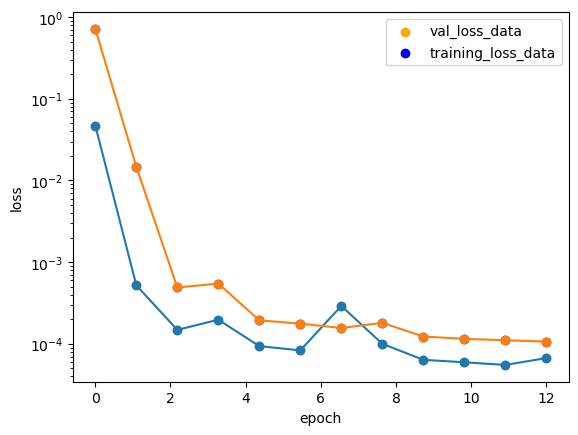

In [59]:
data = val_loss_data
data2 = training_loss_data
x = np.linspace(0,epoch, epoch)
plt.scatter(x, data, color='orange', label='val_loss_data')
plt.plot(x, data, '-o')
plt.scatter(x, data2, color='blue', label='training_loss_data')
plt.plot(x, data2, '-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

In [60]:
rand_dens = np.random.uniform(2.3,11.23)
rand_temp = np.random.uniform(1,6.4)
rand_flor = np.random.uniform(1e-4,1e-2)
rand_err = np.random.uniform(0.0,0.2)
print(f'dens = {rand_dens}, temp = {rand_temp}, flor = {rand_flor}, noise = {rand_err}')


energy_intensity_dfVH  = plotter(rand_dens,rand_temp,rand_flor, rand_err)
energy_intensity_dfVH = energy_intensity_dfVH.iloc[1,:]
energy_intensity_npVH = energy_intensity_dfVH.to_numpy()
energy_intensity_npVH = energy_intensity_npVH.reshape(1, -1)

dens = 5.938018182005806, temp = 6.019188812040075, flor = 0.008873933244506506, noise = 0.13419189700691364
5e-05


In [61]:
def snv(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std_dev = np.std(data, axis=1, keepdims=True)
    return (data - mean) / std_dev

In [62]:
SNVslice = snv(energy_intensity_npVH)
SNVslice = np.concatenate([EIDPCA.transform(SNVslice)[0],[np.array(min(energy_intensity_npVH[0]))],[np.array(max(energy_intensity_npVH[0][0:250]))],[np.array(max(energy_intensity_npVH[0][250:750]))],[np.array(max(energy_intensity_npVH[0][750:1100]))],[np.array(max(energy_intensity_npVH[0][2500:2995]))]]) 


# slicer = ROIPCA.transform(ROIscaler.transform(np.concatenate((hea,lya)).reshape(1,-1))
SNVslice.shape

(8,)

In [63]:
model.eval()
with torch.no_grad():  # Turn off gradients since we're in inference mode
    model = model.cpu()
    outputs = model(torch.tensor(SNVslice, dtype=torch.float32))
    
predicted_labels = outputs.detach().numpy()  # Convert to numpy 
predicted_labels = pd.DataFrame(predicted_labels.reshape(1,-1))
predicted_labels.iloc[:, 0] = DensityScaler.inverse_transform(predicted_labels.iloc[:, 0].values.reshape(-1, 1)).flatten()
predicted_labels.iloc[:, 1] = TempScaler.inverse_transform(predicted_labels.iloc[:, 1].values.reshape(-1, 1)).flatten()
#predicted_labels.iloc[:, 2] = HEFScaler.inverse_transform(predicted_labels.iloc[:, 2].values.reshape(-1, 1)).flatten()


#predicted_labels[2] = np.power(10, predicted_labels[2])
predicted_labels = predicted_labels.to_numpy()[0]
print("Predicted Output:", predicted_labels)

Predicted Output: [5.9270644 5.9994164]


5e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


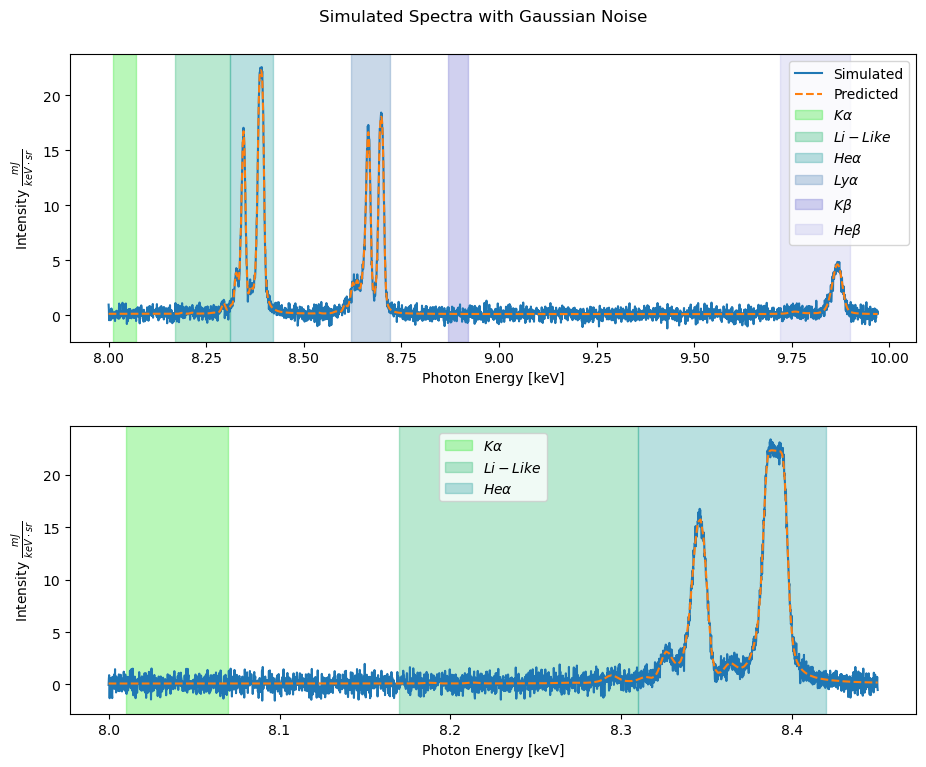

In [64]:
_ = plotter(rand_dens,rand_temp,rand_flor, rand_err,dens2=predicted_labels[0],temp2=predicted_labels[1],ploton=True,compare = True)
#_ = plotter([18,18,2.23],[6.4,0.1],rand_flor, rand_err,dens2=predicted_labels[0],temp2=predicted_labels[1],ploton=True,compare = False)

In [65]:
#Define energy axes, density layers, and temp layers
num_trials = 1000
scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
dx = 5e-5 #Single layer of thickness 500 nm
# get interpolators for j,k, and fluorescence
j,k,j_f,k_f,fh,fj = scram.get_scram_intrp(dx) #Extracts j, k from SCRAM
en_VH = np.linspace(8,9.97,2995) #Spectral range of front side von Hamos spectrometer
en_HR = np.linspace(8,8.45,2995) #Spectral range of rear side spherical crystal spectrometer
intensityVH = []
intensityHR = []
variables = []

for i in range(num_trials):

    dens = np.random.uniform(2.23,10.764) #Solid Density copper LOW BoUND: 2.23; HIGH BOUND 18.00
    temp = np.random.uniform(1,6.4) #Reasonable temperature of 3.5 keV #LOW BOUND 0.10; HIGH BOUND 6.40
    flor = 1e-3
    error = 0 #controls how noisy the spectra are
     #Generates class object with the specified parameters
    #generating test spectra with noise
    target = SCRAMTarget([dens],[temp],j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx)
    test_VH, test_HR = target.model([dens],[temp],flor,100)
    noise_VH = np.random.normal(0,error*np.std(test_VH),en_VH.shape)
    noise_HR = np.random.normal(0,error*np.std(test_HR),en_HR.shape)
  
    print(i)
    intensityVH.append(test_VH+noise_VH)
    intensityHR.append(test_HR+noise_HR)
    variables.append([dens, temp,flor])

energy_intensity_dfVH = pd.concat([pd.DataFrame(en_VH.reshape(1,-1)),pd.DataFrame(intensityVH)])
energy_intensity_dfHR = pd.concat([pd.DataFrame(en_VH.reshape(1,-1)),pd.DataFrame(intensityHR)])
dens_temp_noise_df = pd.DataFrame(variables)

5e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


In [66]:
a_real, a_guess, b_real, b_guess, c_real, c_guess  = [], [], [], [], [], []
#c_real, c_guess = [], []

for i in range(0,num_trials):
    energy_intensity_dfVHslice = energy_intensity_dfVH.iloc[i+1,:]
    energy_intensity_npVH = energy_intensity_dfVHslice.to_numpy()
    energy_intensity_npVH = energy_intensity_npVH.reshape(1, -1)
    

    slicer = EIDPCA.transform(snv(energy_intensity_npVH))
    SNVslice = np.concatenate([slicer[0],[np.array(min(energy_intensity_npVH[0]))],[np.array(max(energy_intensity_npVH[0][0:250]))],[np.array(max(energy_intensity_npVH[0][250:750]))],[np.array(max(energy_intensity_npVH[0][750:1100]))],[np.array(max(energy_intensity_npVH[0][2500:2995]))]]) 



    test_tensor = torch.tensor(SNVslice, dtype=torch.float32)
    
    
    
    

    model.eval()
    with torch.no_grad():  # Turn off gradients since we're in inference mode
    
        outputs = model(test_tensor)
        predicted_labels = outputs.detach().numpy()  # Convert to numpy 
     
        predicted_labels = pd.DataFrame(predicted_labels.reshape(1,-1))
        predicted_labels.iloc[:, 0] = DensityScaler.inverse_transform(predicted_labels.iloc[:, 0].values.reshape(-1, 1)).flatten()
        predicted_labels.iloc[:, 1] = TempScaler.inverse_transform(predicted_labels.iloc[:, 1].values.reshape(-1, 1)).flatten()
        predicted_labels = predicted_labels.to_numpy()
    
    a_real.append(dens_temp_noise_df.iloc[i,:].to_numpy().flatten()[0])
    a_guess.append(predicted_labels.flatten()[0])
    b_real.append(dens_temp_noise_df.iloc[i,:].to_numpy().flatten()[1])
    b_guess.append(predicted_labels.flatten()[1])
    # c_real.append(dens_temp_noise_df.iloc[i,:].to_numpy().flatten()[2])
    # c_guess.append(predicted_labels.flatten()[2])    


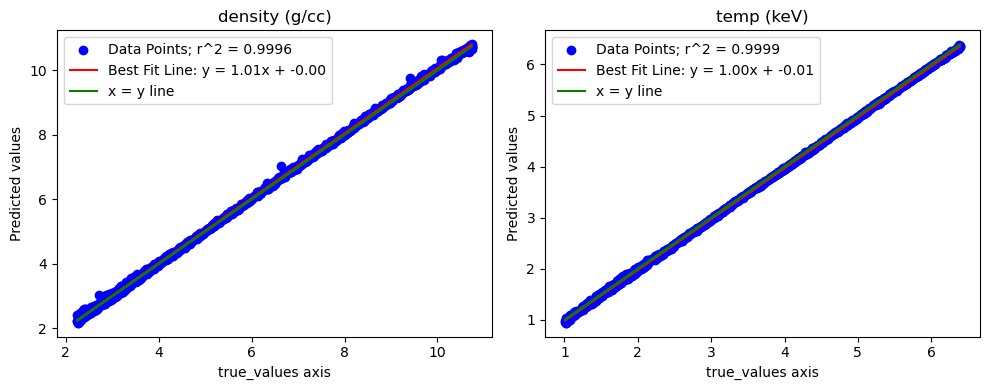

In [67]:
def plotabc(real, guess, name,ax):
    slope, intercept, r, p, std_err = stats.linregress(real, guess)
    r2 = r**2
    
    line = slope * np.array(real) + intercept
    ax.scatter(real, guess, color='blue', label=f'Data Points; r^2 = {r2:0.4f}')
    ax.plot(real, line, color='red', label=f'Best Fit Line: y = {slope:.2f}x + {intercept:.2f}')
    ax.plot(real, real, color='green', label=f'x = y line')
    ax.set_xlabel('true_values axis')
    ax.set_ylabel('Predicted values')
    ax.set_title(f'{name}')
    ax.legend()
    # print(slope)
    # print(intercept)
    


_, axs = plt.subplots(1, 2, figsize=(10, 4))
plotabc(a_real, a_guess, 'density (g/cc)',axs[0])
plotabc(b_real, b_guess, 'temp (keV)',axs[1])
#plotabc(c_real, c_guess, 'Hot electron fraction (unitless)',axs[2])
plt.tight_layout()

0.9205303372961202
1.0565018855508261


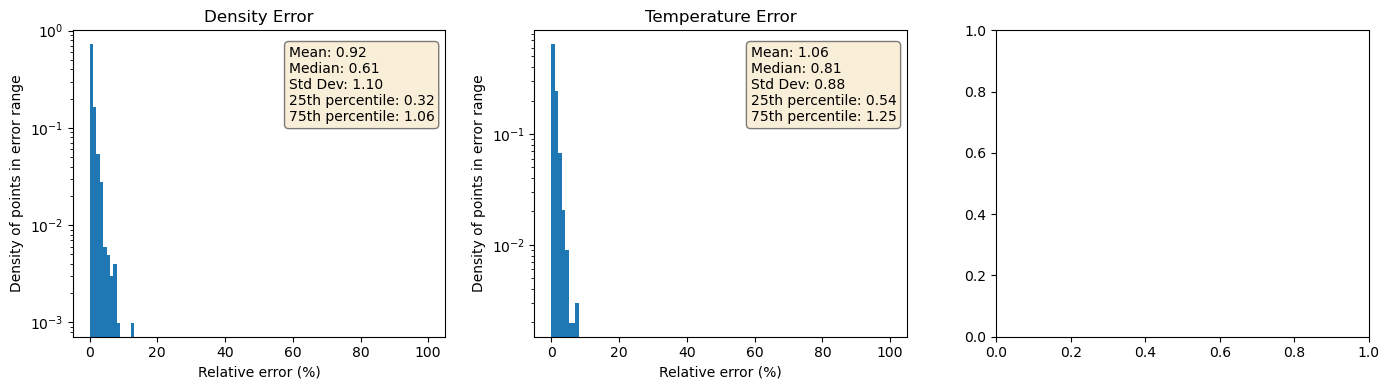

0.999


In [68]:
def coefficient_error(guess, real):
    error = abs((np.array(guess)-np.array(real))/np.array(real)*100)
    return error


a_error = (coefficient_error(a_guess, a_real)).tolist()
b_error = (coefficient_error(b_guess, b_real)).tolist()
#c_error = (coefficient_error(c_guess, c_real)).tolist()

def plot_hist(errors, title, ax):
    bins = np.linspace(0, 100, 100)
    ax.hist(errors, bins=bins, log=True,density = True )
    ax.set_title(title)
    ax.set_xlabel('Relative error (%)')
    ax.set_ylabel('Density of points in error range')
    
    mean = np.mean(errors)
    print(mean)
    median = np.median(errors)
    mode_result = stats.mode(errors)
    modex = mode_result.mode if mode_result.count.size > 0 else "No mode"
    std_dev = np.std(errors)
    percentile_25 = np.percentile(errors, 25)
    percentile_75 = np.percentile(errors, 75)
    
    textstr = '\n'.join((
        f'Mean: {mean:.2f}',
        f'Median: {median:.2f}',
        #f'Mode: {modex:.2f}' if modex != "No mode" else f'Mode: {modex}',
        f'Std Dev: {std_dev:.2f}',
        f'25th percentile: {percentile_25:.2f}',
        f'75th percentile: {percentile_75:.2f}'
    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.58, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

_, axs = plt.subplots(1, 3, figsize=(14, 4))

plot_hist(a_error, 'Density Error', axs[0])
plot_hist(b_error, 'Temperature Error', axs[1])
#plot_hist(c_error, 'HEF Error', axs[2])
plt.tight_layout()
plt.show()

count = len([x for x in a_error if x < 10])/len(a_error)
print(count)

In [105]:
torch.save(model.state_dict(),f'{base_path}\\models\\highNN.pth')

In [69]:
def adjust(spec_VH, spec_HR):
      baselineVH,baselineHR = np.zeros((0, 2995)),np.zeros((0, 2995))

      xVH = np.linspace(8,9.97,2995)
      xHR = np.linspace(8,8.45,2995)
      mask = np.zeros(2995, dtype=bool)
      mask[16:107] = True #1
      mask[259:472] = True  #6
      mask[472:639] = True  #6
      mask[943:1095] = True  #6
      mask[1323:1399] = True  #6
      mask[2615:2888] = True  #6
      baselineVH_indices = np.where(~mask)[0]
      baselineVH = np.array(spec_VH[baselineVH_indices])
      baselineVH = np.insert(baselineVH, 16, spec_VH[107:198])
      baselineVH = np.insert(baselineVH, 259, spec_VH[107:168])
      baselineVH = np.insert(baselineVH, 320, spec_VH[107:259])
      baselineVH = np.insert(baselineVH, 472, spec_VH[700:867])
      baselineVH = np.insert(baselineVH, 943, spec_VH[1095:1247])
      baselineVH = np.insert(baselineVH, 1323, spec_VH[1247:1323])
      baselineVH = np.insert(baselineVH, 2615, spec_VH[2449:2615])
      baselineVH = np.append(baselineVH, spec_VH[2721:2828])
      mask = np.zeros(2995, dtype=bool)
      mask[1132:2795] = True
      baselineHR_indices = np.where(~mask)[0]
      baselineHR = np.array(spec_HR[baselineHR_indices])
      baselineHR = np.insert(baselineHR, 1132, spec_HR[0:1132])
      baselineHR = np.insert(baselineHR, 2264, spec_HR[2795:2995])
      baselineHR = np.insert(baselineHR, 2464, spec_HR[2795:2995])
      baselineHR = np.insert(baselineHR, 2664, spec_HR[2795:2926])
      z = np.polyfit(xVH, baselineVH, 1)
      f = np.poly1d(z)
      # plt.plot(xVH,f(xVH),"g",label = "Slope")
      zz = np.polyfit(xHR, baselineHR, 1)
      g = np.poly1d(zz)
      # print(f)
      # print(g)
      
      spec_VH_l = spec_VH + f(xVH)
      spec_HR_l = spec_HR + g(xHR)

      spec_VH = spec_VH - f(xVH)
      spec_HR = spec_HR - g(xHR)

      return spec_VH, spec_HR, spec_VH_l, spec_HR_l

In [70]:
data_dir = "2020_LaserNetCSUCombinedData"
os.chdir(f'{base_path}\\{data_dir}\\SCRAM\\Code')
from import_scram import SCRAM
from simulate_scram import SCRAMTarget
from get_data import get_intrp
os.chdir(base_path)

In [113]:
#import data from Dec 17,2020 for 0.5um Cu with best focus

#cu @ 0.5um are: 19-26 20201215

shotlist = [23]#[18,19,20]
exp_path = f'{base_path}\\{data_dir}\\Data\\20201217\\CombinedData' #absolute path to shots
spec_VH, spec_HR, err_VH, err_HR = get_intrp(exp_path, shotlist) #intrp for data
en_VH = np.linspace(8, 9.97, 2995) #Energy axis FRONT
en_HR = np.linspace(8, 8.45, 2995) #Energy axis REAR

#creating arrays from the data
spec_VH = spec_VH(en_VH)
spec_HR = spec_HR(en_HR)
err_VH = err_VH(en_VH)
err_HR = err_HR(en_HR)

Current Shots: 

Number: 24	Target: 0.5um Cu		Focus: 100um Defocus

2000


In [114]:
spec_VH, spec_HR, spec_VH_l, spec_HR_l = adjust(spec_VH, spec_HR)

In [115]:
spec_VH = [spec_VH]
SNVslice = snv(spec_VH)

In [116]:
SNVslicePCA = np.concatenate([EIDPCA.transform(SNVslice)[0],[np.array(min(spec_VH[0]))],[np.array(max(spec_VH[0][0:250]))],[np.array(max(spec_VH[0][250:750]))],[np.array(max(spec_VH[0][750:1100]))],[np.array(max(spec_VH[0][2500:2995]))]]) 

# slicer = ROIPCA.transform(ROIscaler.transform(np.concatenate((hea,lya)).reshape(1,-1))
SNVslicePCA.shape

(8,)

In [117]:
model.eval()
with torch.no_grad():  # Turn off gradients since we're in inference mode
    model = model.cpu()
    outputs = model(torch.tensor(SNVslicePCA, dtype=torch.float32))
    
predicted_labels = outputs.detach().numpy()  # Convert to numpy 
predicted_labels = pd.DataFrame(predicted_labels.reshape(1,-1))
predicted_labels.iloc[:, 0] = DensityScaler.inverse_transform(predicted_labels.iloc[:, 0].values.reshape(-1, 1)).flatten()
predicted_labels.iloc[:, 1] = TempScaler.inverse_transform(predicted_labels.iloc[:, 1].values.reshape(-1, 1)).flatten()
#predicted_labels.iloc[:, 2] = HEFScaler.inverse_transform(predicted_labels.iloc[:, 2].values.reshape(-1, 1)).flatten()


#predicted_labels[2] = np.power(10, predicted_labels[2])
predicted_labels = predicted_labels.to_numpy()[0]
print("Predicted Output:", predicted_labels)

Predicted Output: [4.298489 2.150223]


5e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


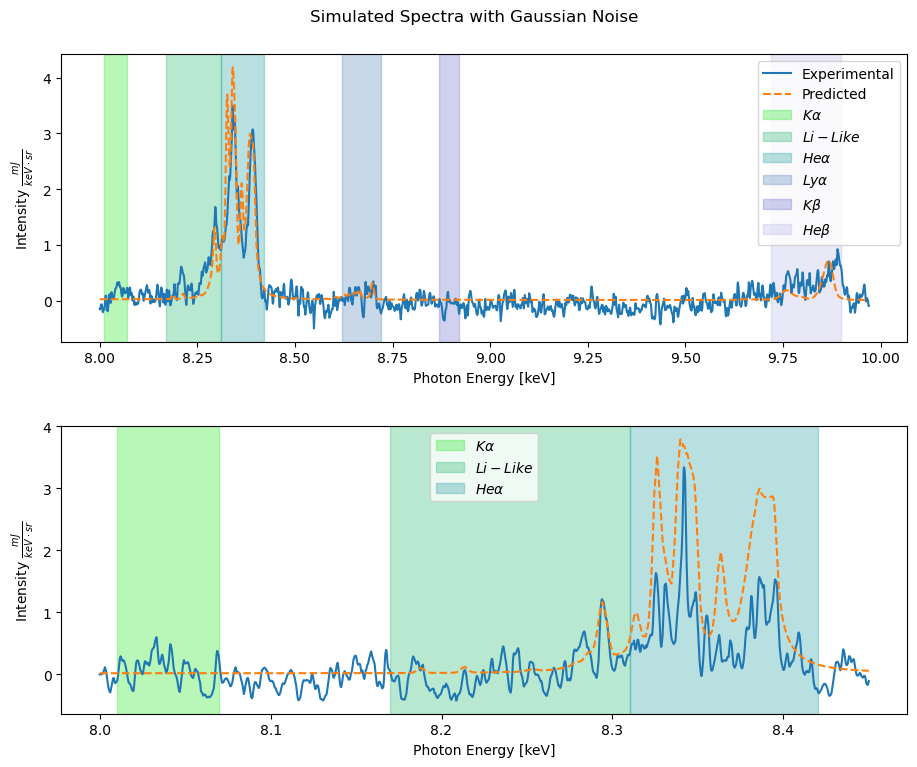

In [118]:
_ = plotter2(predicted_labels[0],predicted_labels[1],1e-3,0,dx=5e-5,exp_specVH = spec_VH[0],exp_specHR = spec_HR,ploton = True, compare=True)

In [ ]:
SNVslice

array([[0.49382654, 0.61069828, 0.69529194, ..., 0.5554053 , 0.37515024,
        0.11408991]])

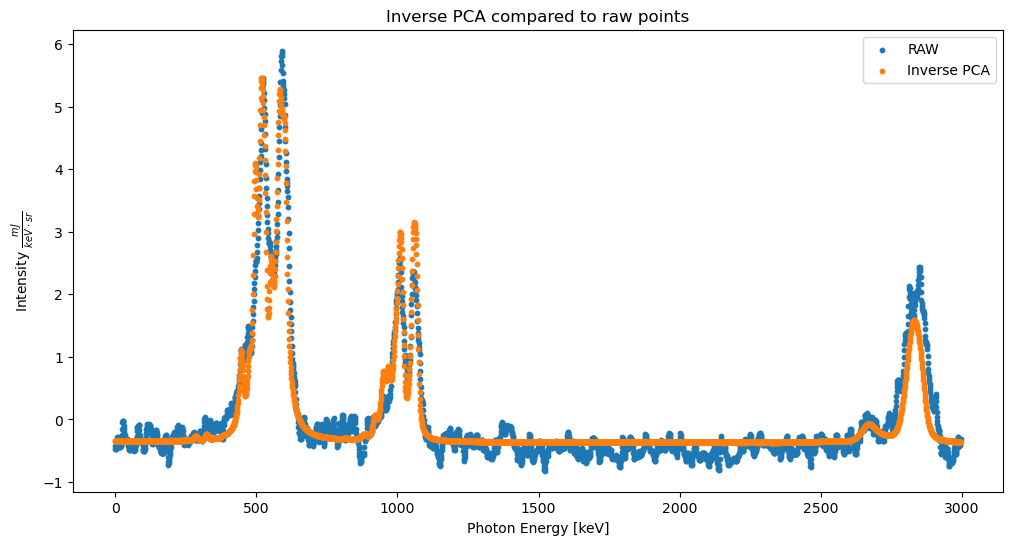

In [106]:
test = EIDPCA.inverse_transform(EIDPCA.transform(SNVslice))
plt.figure(figsize=(12, 6))  # Make the plot wider by setting the figure size
plt.scatter(np.linspace(0, len(SNVslice[0]), len(SNVslice[0])), SNVslice[0], s=10, label = 'RAW')  # Make dots smaller with 's' parameter
plt.scatter(np.linspace(0, len(test[0]), len(test[0])), test[0], s=10, label = 'Inverse PCA')  # Make dots smaller with 's' parameter
plt.xlabel('Photon Energy [keV]')  
plt.ylabel(r'Intensity $\frac{mJ}{keV\cdot sr}$')  
plt.title('Inverse PCA compared to raw points')  
plt.legend()
plt.show()